In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython import display
from scipy.spatial import cKDTree

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.dynamics import mockstream as ms

from scipy.interpolate import InterpolatedUnivariateSpline
import imf

import sys
if '../scripts' not in sys.path:
    sys.path.append('../scripts')
from streamsubhalosim import get_in_stream_frame, StreamSubhaloSimulation

In [2]:
mw = gp.load(
    "/mnt/home/apricewhelan/projects/gaia-actions/potentials/MilkyWayPotential2022.yml"
)

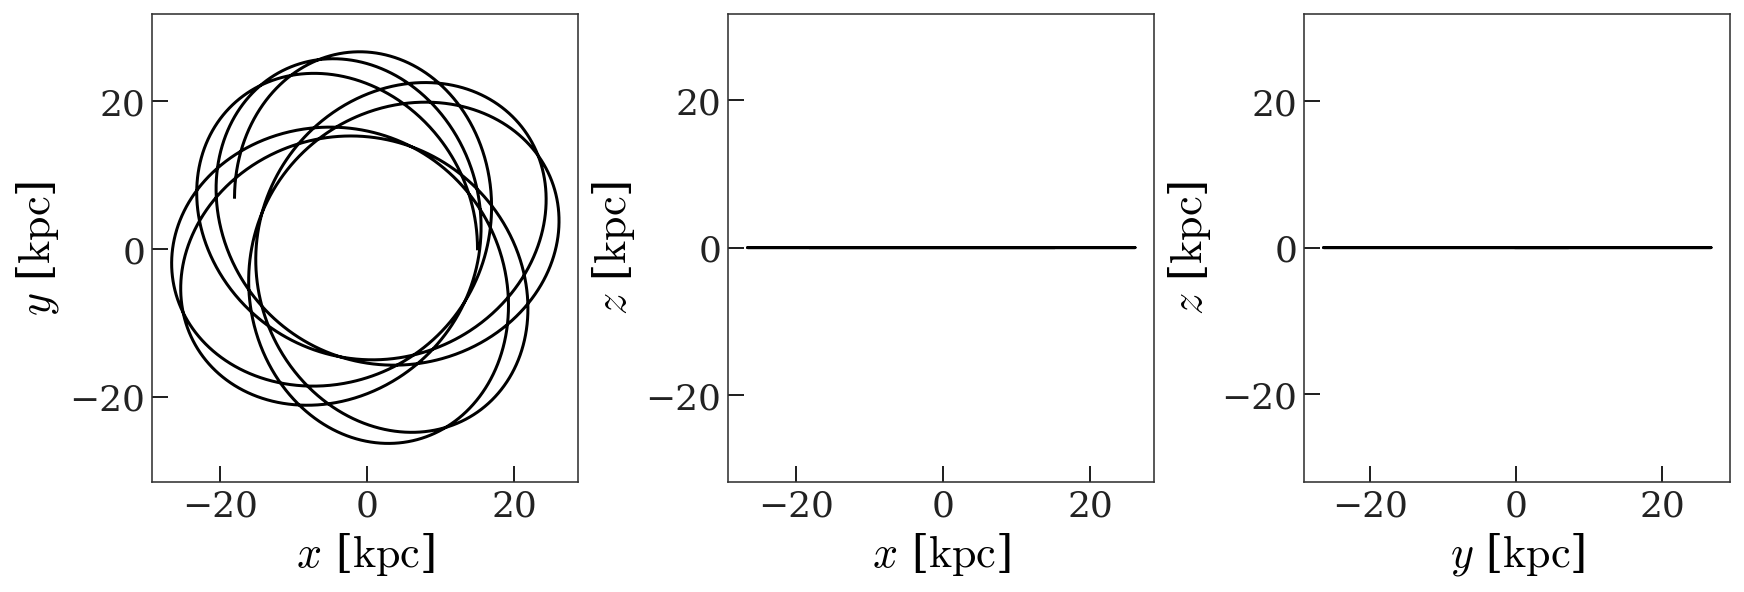

In [3]:
wf = gd.PhaseSpacePosition(pos=[15, 0.0, 0.0] * u.kpc, vel=[0, 275, 0] * u.km / u.s)
orbit = mw.integrate_orbit(wf, dt=1.0, t1=0, t2=4 * u.Gyr)
orbit.plot();


In [4]:
sim = StreamSubhaloSimulation(
    mw_potential=mw,
    final_prog_w=wf,
    M_stream=5e4 * u.Msun,
    t_pre_impact=3 * u.Gyr,
    t_post_impact=200 * u.Myr,
    n_particles=1,
    seed=42,
)


In [5]:
init_stream, init_prog = sim.run_init_stream()
impact_site = sim.get_impact_site(init_stream, init_prog)

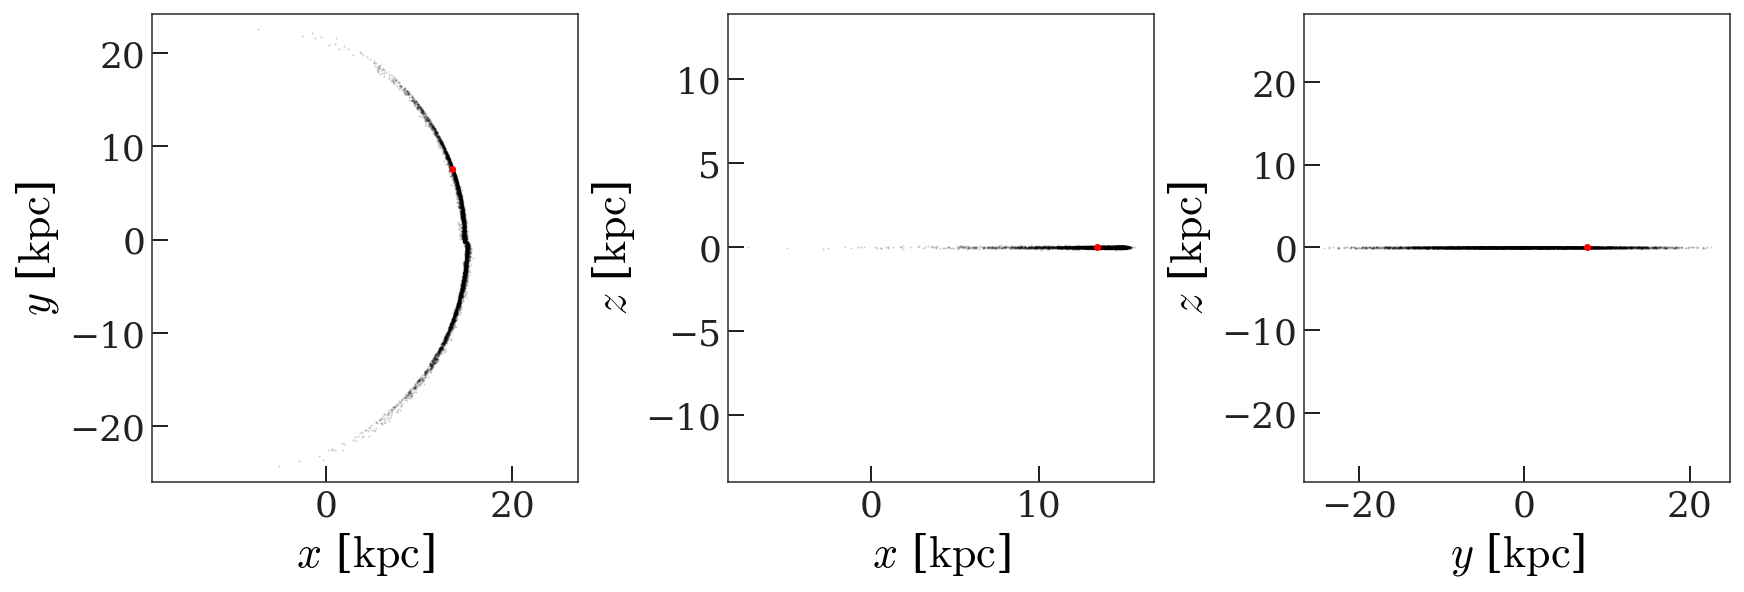

In [6]:
stream_style = dict(marker="o", ms=1.0, ls="none", alpha=0.2, plot_function=plt.plot)
fig = init_stream.plot(**stream_style)
impact_site.plot(color="r", axes=fig.axes, autolim=False, zorder=100);

In [7]:
derp = get_in_stream_frame(init_stream, prog=init_prog[0], impact=impact_site)

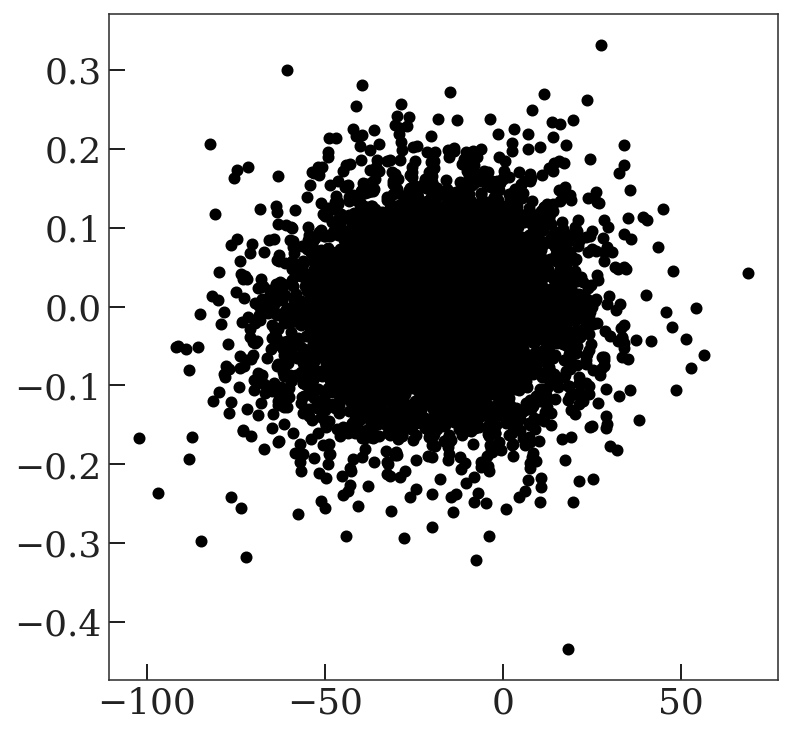

In [8]:
plt.scatter(derp.phi1.degree, derp.phi2.degree)

In [8]:
import gala.coordinates as gc

In [13]:
dir(gc.GreatCircleICRSFrame)

['T',
 '_APPLICABLE_FUNCTIONS',
 '_METHOD_FUNCTIONS',
 '__abstractmethods__',
 '__array_function__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_apply',
 '_create_readonly_property',
 '_data_repr',
 '_default_differential',
 '_default_representation',
 '_default_wrap_angle',
 '_frame_attrs_repr',
 '_frame_class_cache',
 '_frame_specific_representation_info',
 '_frameattr_equiv',
 '_get_representation_info',
 '_infer_data',
 '_infer_repr_info',
 '_infer_representation',
 '_replicate',
 'cache',
 'cartesian',
 'copy',
 'cylindrical',
 'data',
 'default_differential',

In [7]:
xhat = impact_site.xyz / np.linalg.norm(impact_site.xyz)
yhat = impact_site.v_xyz / np.linalg.norm(impact_site.v_xyz)
xhat = xhat - xhat.dot(yhat) * yhat
zhat = np.cross(xhat, yhat)
R = np.stack((xhat, yhat, zhat)).T

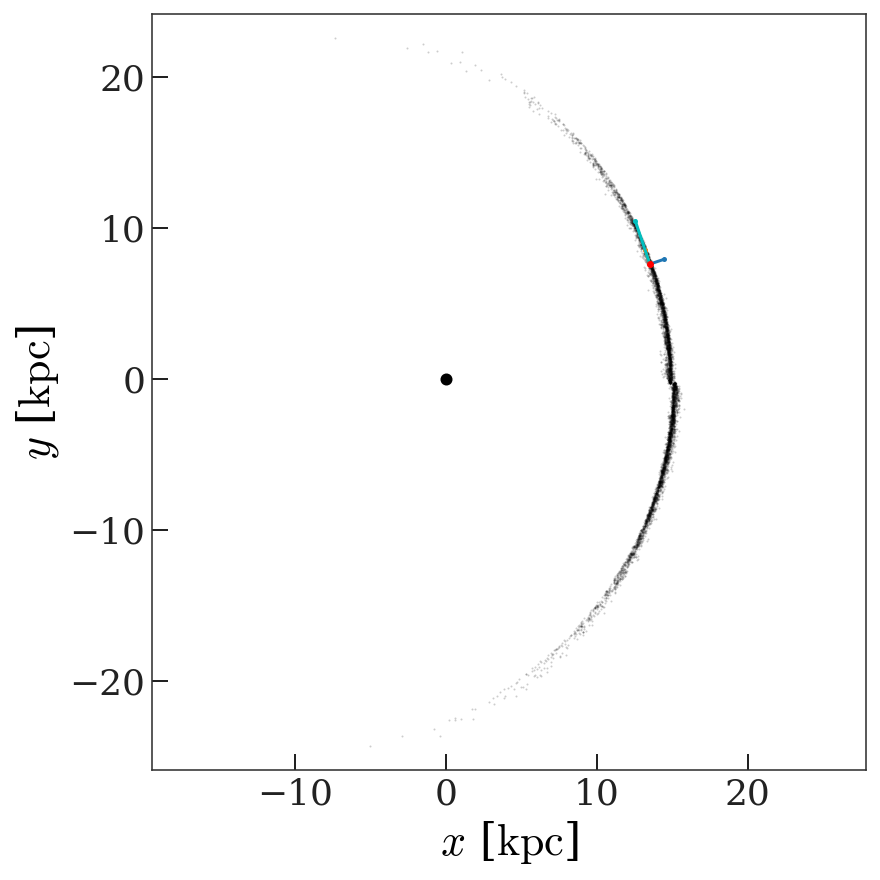

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
fig = init_stream.plot(['x', 'y'], axes=[ax], **stream_style)
impact_site.plot(['x', 'y'], axes=[ax], color="r", autolim=False, zorder=100);

for tmp in [xhat, yhat]:
    ax.plot(
        [impact_site.x.value, impact_site.x.value + tmp[0]],
        [impact_site.y.value, impact_site.y.value + tmp[1]]
    )
ax.scatter([0], [0])

xx = np.array([0., 1, 0])
tmp = 3 * (R @ xx)
ax.plot(
    [impact_site.x.value, impact_site.x.value + tmp[0]],
    [impact_site.y.value, impact_site.y.value + tmp[1]],
    color='c'
)

In [9]:
M_subhalo = 1e8 * u.Msun
c_subhalo = 1.005 * u.kpc * (M_subhalo / (1e8 * u.Msun)) ** 0.5 / 2.0  # 1-sigma denser
impact_v = 50 * u.pc/u.Myr
impact_b = c_subhalo

rng = np.random.default_rng(42)
dxdv = (rng.normal(size=3), rng.normal(size=3))
dx = dxdv[0] / np.linalg.norm(dxdv[0]) * impact_b
dv = dxdv[1] / np.linalg.norm(dxdv[1]) * impact_v

MAGIC = 32
stream_after_impact, unpert_stream_post, prog_end = sim.run_perturbed_stream(
    impact_site_w=impact_site,
    subhalo_impact_dw=gd.PhaseSpacePosition(dx, dv),
    subhalo_potential=gp.HernquistPotential(
        m=M_subhalo, c=c_subhalo, units=galactic
    ),
    t_buffer_impact=np.round((MAGIC * c_subhalo / impact_v).to(u.Myr)),
    impact_dt=np.round((c_subhalo / impact_v / MAGIC).to(u.Myr), decimals=2),
)

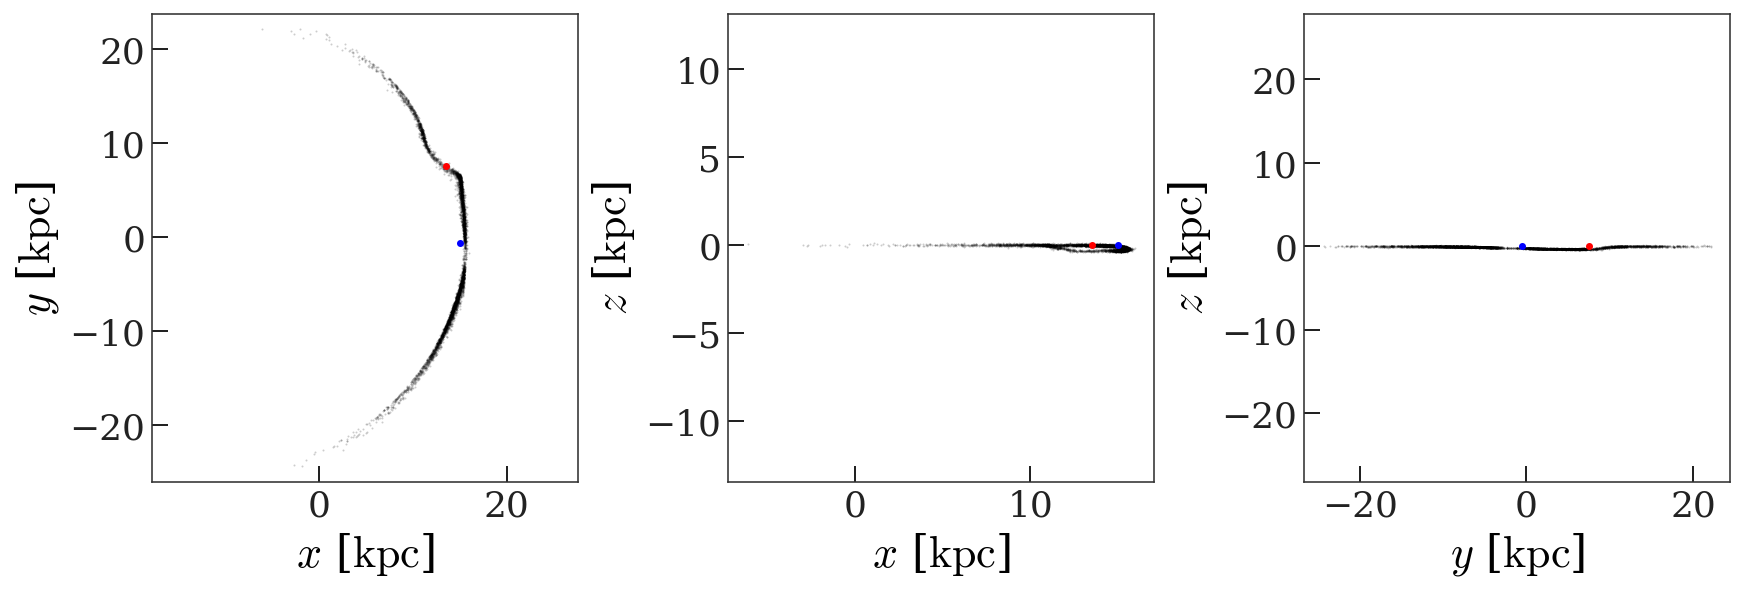

In [12]:
stream_style = dict(marker="o", ms=1.0, ls="none", alpha=0.2, plot_function=plt.plot)
fig = stream_after_impact.plot(**stream_style)
impact_site.plot(color="r", axes=fig.axes, autolim=False, zorder=100);
prog_end.plot(color="b", axes=fig.axes, autolim=False, zorder=100);

In [6]:
# self = sim

# impact_site_w = impact_site
# subhalo_impact_dw = gd.PhaseSpacePosition(dx, dv)
# subhalo_potential = gp.HernquistPotential(
#     m=M_subhalo, c=c_subhalo, units=galactic
# )
# t_buffer_impact = None
# impact_dt = None

# subhalo_v = np.linalg.norm(subhalo_impact_dw.v_xyz)
# if t_buffer_impact is None:
#     t_buffer_impact = np.round((1 * u.kpc / subhalo_v).to(u.Myr), decimals=1)
# if impact_dt is None:
#     impact_dt = (1.0 * u.pc / subhalo_v).to(u.Myr)

# w_subhalo_impact = gd.PhaseSpacePosition(
#     impact_site_w.xyz + subhalo_impact_dw.xyz,
#     impact_site_w.v_xyz + subhalo_impact_dw.v_xyz,
# )
# w_subhalo_buffer = self.H.integrate_orbit(
#     w_subhalo_impact,
#     dt=-self.dt / 10,
#     t1=t_buffer_impact,
#     t2=0,
#     Integrator=gi.Ruth4Integrator,
#     store_all=False,
# )[0]

# stream_buffer_pre, prog_w_buffer_pre = self._mockstream_gen.run(
#     self._prog_w0,
#     self.M_stream,
#     dt=self.dt,
#     t1=0,
#     t2=self.t_pre_impact - t_buffer_impact,
#     **self._mockstream_kw,
# )

# tmp = gd.PhaseSpacePosition(
#     stream_buffer_pre.pos, stream_buffer_pre.vel, frame=stream_buffer_pre.frame
# )
# nbody_w0 = gd.combine((w_subhalo_buffer, tmp))

# null_potential = gp.NullPotential(units=galactic)
# nbody = gd.DirectNBody(
#     w0=nbody_w0,
#     particle_potentials=[subhalo_potential] + [null_potential] * tmp.shape[0],
#     external_potential=self.H.potential,
#     frame=self.H.frame,
#     save_all=False,
# )

# if (self.t_pre_impact + t_buffer_impact) > (
#     self.t_pre_impact + self.t_post_impact
# ):
#     t2 = self.t_pre_impact + self.t_post_impact
#     tf = np.nan
# else:
#     t2 = self.t_pre_impact + t_buffer_impact
#     tf = self.t_pre_impact + self.t_post_impact

# stream_impact = nbody.integrate_orbit(
#     dt=impact_dt,
#     t1=self.t_pre_impact - t_buffer_impact,
#     t2=t2,
# )
# if not np.isnan(tf):
#     stream_after_impact = self.H.integrate_orbit(
#         stream_impact,
#         dt=self.dt,
#         t1=self.t_pre_impact + t_buffer_impact,
#         t2=self.t_pre_impact + self.t_post_impact,
#         Integrator=gi.Ruth4Integrator,
#         store_all=False,
#     )[0]
# else:
#     stream_after_impact = stream_impact

# unpert_stream_post, _ = self._mockstream_gen.run(
#     prog_w_buffer_pre[0],
#     self.M_stream,
#     dt=self.dt,
#     t1=self.t_pre_impact - t_buffer_impact,
#     t2=self.t_pre_impact + self.t_post_impact,
#     **self._mockstream_kw,
# )

# w_impact_end = self.H.integrate_orbit(
#     impact_site_w,
#     dt=self.dt,
#     t1=self.t_pre_impact,
#     t2=self.t_pre_impact + self.t_post_impact,
# )[-1]

ValueError: not enough values to unpack (expected 3, got 2)

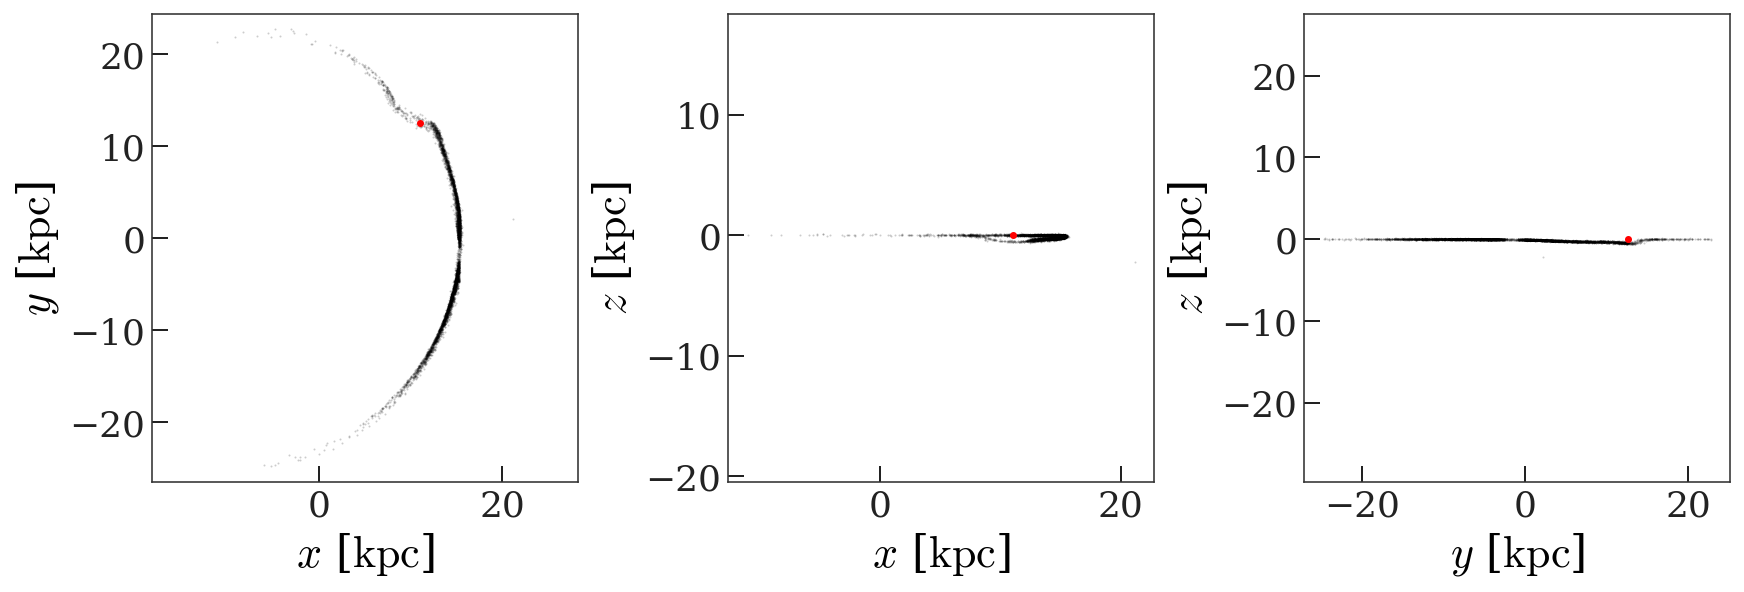

In [40]:
fig = stream_after_impact.plot(**stream_style);
w_impact_end.plot(color="r", axes=fig.axes, autolim=False, zorder=100);
prog_end.plot(color="b", axes=fig.axes, autolim=False, zorder=100);

In [9]:
impact_site_w=rando_star
subhalo_impact_dw=gd.PhaseSpacePosition(
    [1., 0, 0] * impact_b,
    [0, 0, 1.] * impact_v
)
subhalo_potential=gp.HernquistPotential(m=M_subhalo, c=c_subhalo, units=galactic)
t_buffer_impact=np.round((32 * impact_b / impact_v).to(u.Myr))
impact_dt=np.round((c_subhalo / impact_v / 32).to(u.Myr), decimals=2)

NameError: name 'rando_star' is not defined

In [ ]:
subhalo_v = np.linalg.norm(subhalo_impact_dw.v_xyz)
t_buffer_impact = np.round((1 * u.kpc / subhalo_v).to(u.Myr), decimals=1)
impact_dt = (1. * u.pc / subhalo_v).to(u.Myr)

w_subhalo_impact = gd.PhaseSpacePosition(
    impact_site_w.xyz + subhalo_impact_dw.xyz,
    impact_site_w.v_xyz + subhalo_impact_dw.v_xyz,
)
w_subhalo_buffer = self.H.integrate_orbit(
    w_subhalo_impact,
    dt=-self.dt / 10,
    t1=t_buffer_impact,
    t2=0,
    Integrator=gi.Ruth4Integrator,
    store_all=False,
)[0]

stream_buffer_pre, prog_w_buffer_pre = self._mockstream_gen.run(
    self._prog_w0,
    self.M_stream,
    dt=self.dt,
    t1=0,
    t2=self.t_pre_impact - t_buffer_impact,
    **self._mockstream_kw
)

In [ ]:
tmp = gd.PhaseSpacePosition(
    stream_buffer_pre.pos, stream_buffer_pre.vel, frame=stream_buffer_pre.frame
)
nbody_w0 = gd.combine((w_subhalo_buffer, tmp))

null_potential = gp.NullPotential(units=galactic)
nbody = gd.DirectNBody(
    w0=nbody_w0,
    particle_potentials=[subhalo_potential] + [null_potential] * tmp.shape[0],
    external_potential=self.H.potential,
    frame=self.H.frame,
    save_all=False,
)
stream_impact = nbody.integrate_orbit(
    dt=impact_dt,
    t1=self.t_pre_impact - t_buffer_impact,
    t2=self.t_pre_impact + t_buffer_impact,
)

In [ ]:
stream_after_impact = self.H.integrate_orbit(
    stream_impact,
    dt=self.dt,
    t1=self.t_pre_impact + t_buffer_impact,
    t2=self.t_pre_impact + self.t_post_impact,
    Integrator=gi.Ruth4Integrator,
    store_all=False,
)[0]

unpert_stream_post, _ = self._mockstream_gen.run(
    prog_w_buffer_pre[0],
    self.M_stream,
    dt=self.dt,
    t1=self.t_pre_impact - t_buffer_impact,
    t2=self.t_pre_impact + self.t_post_impact,
    **self._mockstream_kw
)

w_impact_end = self.H.integrate_orbit(
    impact_site_w,
    dt=self.dt,
    t1=self.t_pre_impact,
    t2=self.t_pre_impact + self.t_post_impact,
)


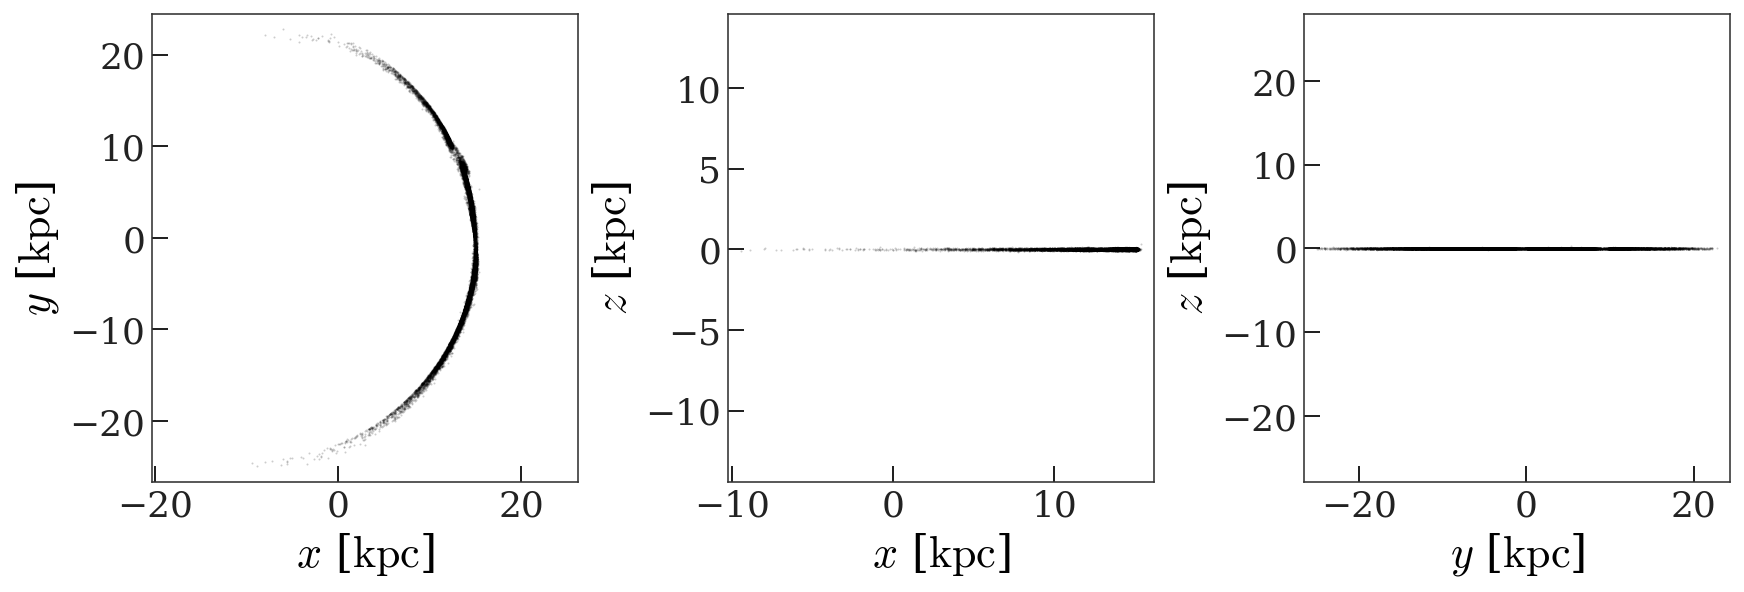

In [ ]:
stream_after_impact.plot(**stream_style);

In [ ]:
d_stream = np.linalg.norm(stream.xyz - rando_star.xyz[:, None], axis=0)
w_impact = gd.PhaseSpacePosition(
    np.mean(stream.xyz[:, d_stream < 1 * u.kpc], axis=1),
    np.mean(stream.v_xyz[:, d_stream < 1 * u.kpc], axis=1),
)
w_impact.plot(["x", "y"], color="c", axes=fig.axes, autolim=False, zorder=100)


In [ ]:
dv_dir = np.array([1, 0, 0.0])
# dv_dir = rng.normal(size=3)
dv_dir /= np.linalg.norm(dv_dir)

dx_dir = np.array([1.0, 0, 0.0])
# dx_dir = rng.normal(size=3)
# dx_dir /= np.linalg.norm(dx_dir)

w_subhalo_impact = gd.PhaseSpacePosition(
    pos=w_impact.xyz + dx_dir * impact_par,
    vel=w_impact.v_xyz + dv_dir * subhalo_v,
)
w_subhalo_buffer = H.integrate_orbit(
    w_subhalo_impact,
    dt=-stream_dt / 10,
    t1=0,
    t2=-t_buffer_impact,
    Integrator=gi.Ruth4Integrator,
    store_all=False,
)[0]


### Parameters

In [ ]:
M_stream = 5e4 * u.Msun

M_subhalo = 5e6 * u.Msun
c_subhalo = 1.005 * u.kpc * (M_subhalo / (1e8 * u.Msun)) ** 0.5 / 4.0  # 1-sigma
subhalo_v = 50 * u.pc / u.Myr
impact_par = c_subhalo

t_buffer_impact = np.round((100 * u.pc / subhalo_v).to(u.Myr), decimals=1)
impact_dt = np.round((1 * u.pc / subhalo_v).to(u.Myr), decimals=2)

c_subhalo.to(u.pc)


<Quantity 56.18120793 pc>

In [ ]:
t_pre_impact = 3 * u.Gyr
t_after_impact = 250 * u.Myr
stream_dt = 0.2 * u.Myr
release_every = 1
n_particles = 4
seed = 42


In [ ]:
movie_dt = 1 * u.Myr


First, run the stream to know where stars end up in unperturbed case:

In [ ]:
rng = np.random.default_rng(seed=seed)
df = ms.FardalStreamDF(random_state=rng)
gen = ms.MockStreamGenerator(df=df, hamiltonian=H)
stream, prog_w = gen.run(
    w0,
    M_stream,
    dt=stream_dt,
    t1=0,
    t2=t_pre_impact,
    release_every=release_every,
    n_particles=1,
    progress=True,
)


Integrating orbits:  100%

In [ ]:
stream_style = dict(marker="o", ms=1.0, ls="none", alpha=0.2, plot_function=plt.plot)


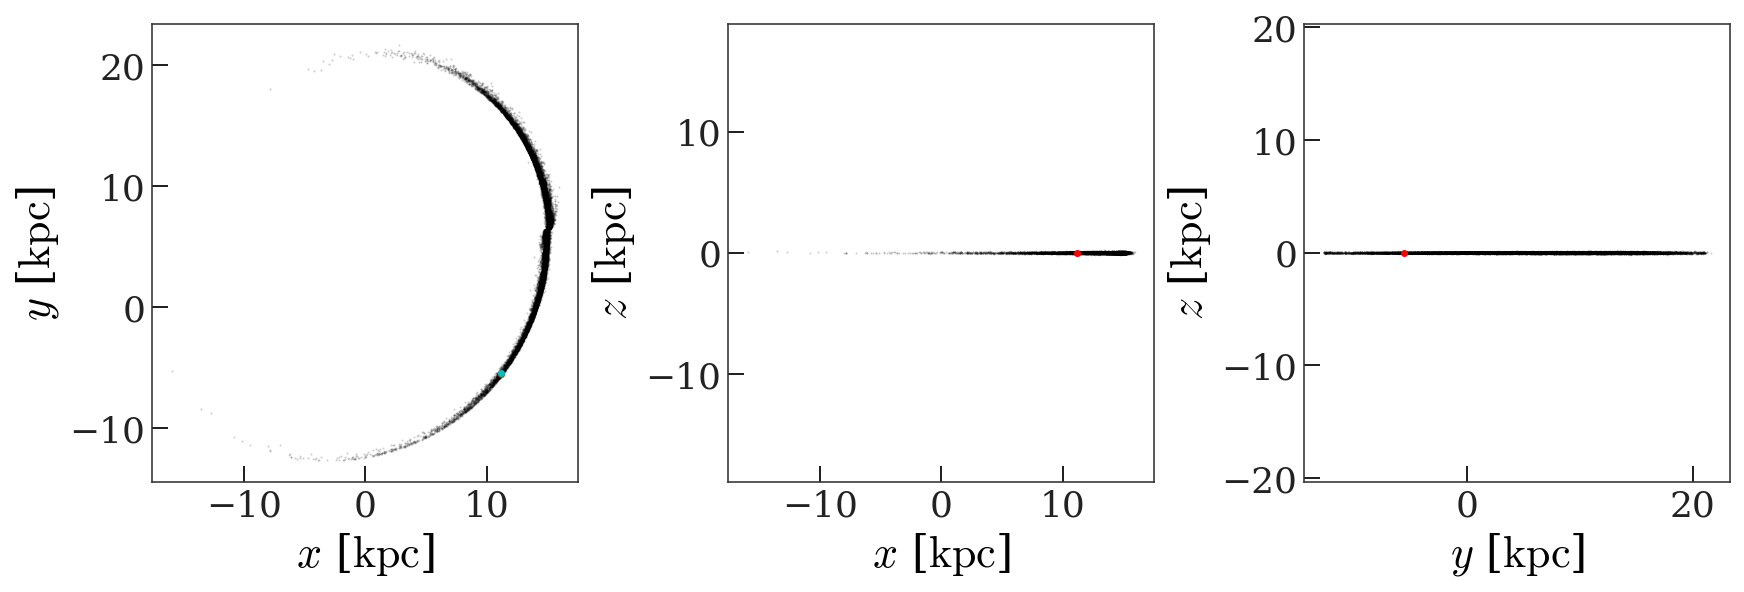

In [ ]:
rng = np.random.default_rng(seed=42)
fig = stream.plot(**stream_style)
rando_star_idx = rng.integers(stream.shape[0])
rando_star = stream[rando_star_idx]
rando_star.plot(color="r", axes=fig.axes, autolim=False, zorder=100)

d_stream = np.linalg.norm(stream.xyz - rando_star.xyz[:, None], axis=0)
w_impact = gd.PhaseSpacePosition(
    np.mean(stream.xyz[:, d_stream < 1 * u.kpc], axis=1),
    np.mean(stream.v_xyz[:, d_stream < 1 * u.kpc], axis=1),
)
w_impact.plot(["x", "y"], color="c", axes=fig.axes, autolim=False, zorder=100)


In [ ]:
dv_dir = np.array([1, 0, 0.0])
# dv_dir = rng.normal(size=3)
dv_dir /= np.linalg.norm(dv_dir)

dx_dir = np.array([1.0, 0, 0.0])
# dx_dir = rng.normal(size=3)
# dx_dir /= np.linalg.norm(dx_dir)

w_subhalo_impact = gd.PhaseSpacePosition(
    pos=w_impact.xyz + dx_dir * impact_par,
    vel=w_impact.v_xyz + dv_dir * subhalo_v,
)
w_subhalo_buffer = H.integrate_orbit(
    w_subhalo_impact,
    dt=-stream_dt / 10,
    t1=0,
    t2=-t_buffer_impact,
    Integrator=gi.Ruth4Integrator,
    store_all=False,
)[0]


In [ ]:
rng = np.random.default_rng(seed=seed)
df = ms.FardalStreamDF(random_state=rng)
gen = ms.MockStreamGenerator(df=df, hamiltonian=H)
stream_buffer_pre, prog_w_buffer_pre = gen.run(
    w0,
    M_stream,
    dt=stream_dt,
    t1=0,
    t2=t_pre_impact - t_buffer_impact,
    release_every=release_every,
    n_particles=n_particles,
    progress=False,
)


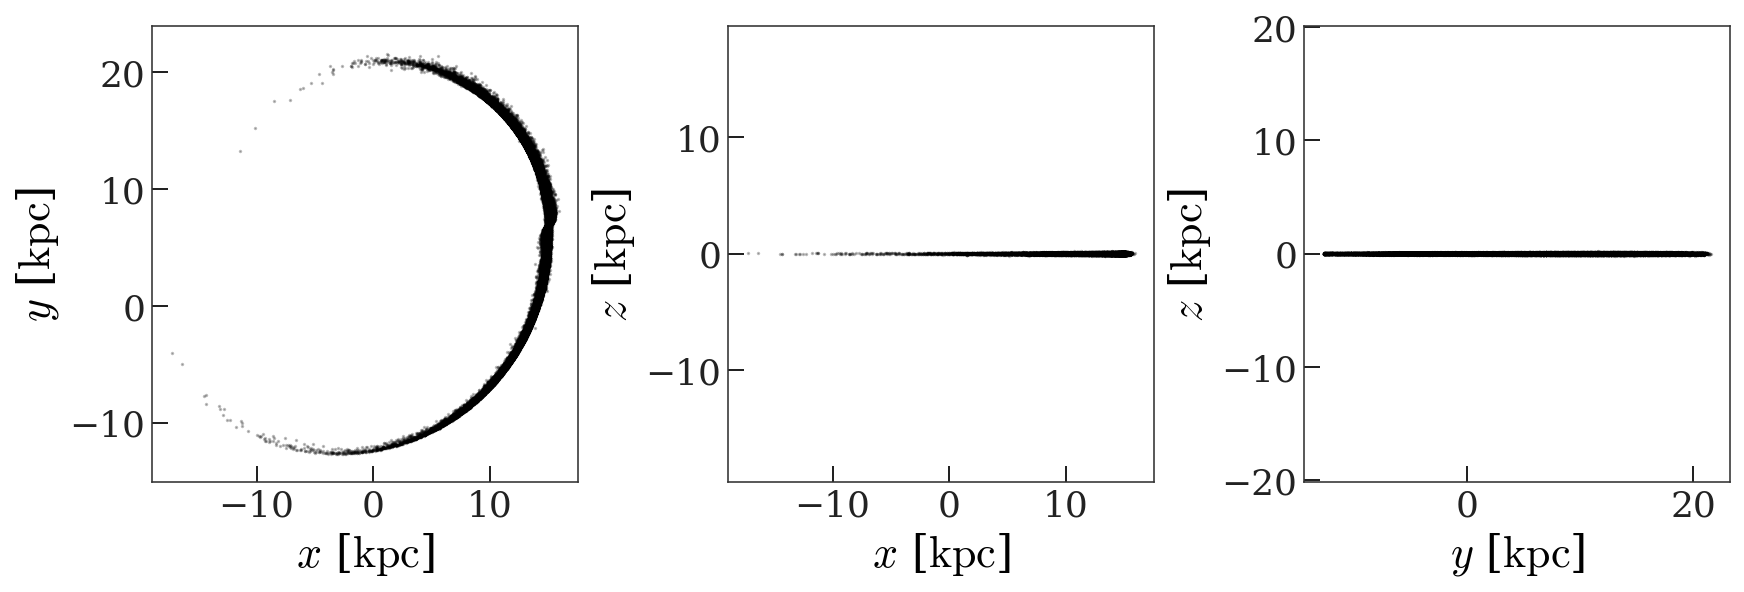

In [ ]:
stream_buffer_pre.plot(s=2.0, alpha=0.25)


In [ ]:
tmp = gd.PhaseSpacePosition(
    stream_buffer_pre.pos, stream_buffer_pre.vel, frame=stream_buffer_pre.frame
)
nbody_w0 = gd.combine((w_subhalo_buffer, tmp))

null_potential = gp.NullPotential(units=galactic)
nbody = gd.DirectNBody(
    w0=nbody_w0,
    particle_potentials=[
        gp.HernquistPotential(m=M_subhalo, c=c_subhalo, units=galactic)
    ]
    + [null_potential] * tmp.shape[0],
    external_potential=H.potential,
    frame=H.frame,
    save_all=True,
)
stream_impact = nbody.integrate_orbit(
    dt=impact_dt, t1=t_pre_impact - t_buffer_impact, t2=t_pre_impact + t_buffer_impact
)


In [ ]:
tmp = mw.integrate_orbit(
    w_subhalo_buffer,
    dt=-stream_dt,
    t1=t_pre_impact - t_buffer_impact,
    t2=0,
    Integrator=gi.Ruth4Integrator,
)

subhalo_orbit = mw.integrate_orbit(
    tmp[-1],
    dt=stream_dt,
    t1=0.0,
    t2=t_pre_impact + t_after_impact,
    Integrator=gi.Ruth4Integrator,
)
mask = np.isclose(subhalo_orbit.t % movie_dt, 0)
subhalo_orbit_movie = subhalo_orbit[mask]


In [ ]:
stream_after_impact = mw.integrate_orbit(
    stream_impact[-1],
    dt=stream_dt,
    t1=t_pre_impact + t_buffer_impact,
    t2=t_pre_impact + t_after_impact,
    Integrator=gi.Ruth4Integrator,
    store_all=True,
)


In [ ]:
unpert_stream_post, _ = gen.run(
    prog_w_buffer_pre[0],
    M_stream,
    dt=stream_dt,
    t1=t_pre_impact - t_buffer_impact,
    t2=t_pre_impact + t_after_impact,
    release_every=release_every,
    n_particles=n_particles,
    progress=False,
    #     output_every=1,
    #     output_filename='../cache/tmp-stream-post.hdf5',
    #     overwrite=True
)


In [ ]:
w_impact_end = H.integrate_orbit(w_impact, dt=0.5 * u.Myr, t1=0, t2=t_after_impact)


In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
kw = dict(components=["x", "y"], axes=[ax])
fig = stream_after_impact[-1].plot(**stream_style, **kw)
# unpert_stream_post.plot(**stream_style, zorder=100, **kw);
w_impact_end[-1].plot(color="tab:red", autolim=False, zorder=100, **kw)


In [ ]:
end_stream = stream_after_impact[-1]
end_stream.shape[0]


119929

### Stellar population

In [ ]:
iso = at.Table.read("/mnt/home/apricewhelan/data/isochrones/mist/FeH_-1.8_iso.fits")
iso = iso[np.isclose(iso["log10_isochrone_age_yr"], 10.0)]


In [ ]:
imf_masses = imf.make_cluster(M_stream.value)  # , mmax=iso['initial_mass'].max())

imf_mask = imf_masses < iso["initial_mass"].max()
imf_masses = imf_masses[imf_mask]
imf_masses = rng.choice(imf_masses, size=end_stream.shape[0], replace=True)

imf_masses.sum(), len(imf_masses)


Total cluster mass is 49999.6 (limit was 50000)


(24523.461765479733, 119929)

In [ ]:
interp_mass2eep = InterpolatedUnivariateSpline(iso["initial_mass"], iso["EEP"], k=1)
imf_eeps = interp_mass2eep(imf_masses)

eep2mag_interps = {}
for mag in ["g", "r", "i"]:
    eep2mag_interps[mag] = InterpolatedUnivariateSpline(
        iso["EEP"], iso[f"ps1_{mag}"], k=1
    )


In [ ]:
phot = at.Table()
for k, func in eep2mag_interps.items():
    phot[f"M_{k}"] = func(imf_eeps)


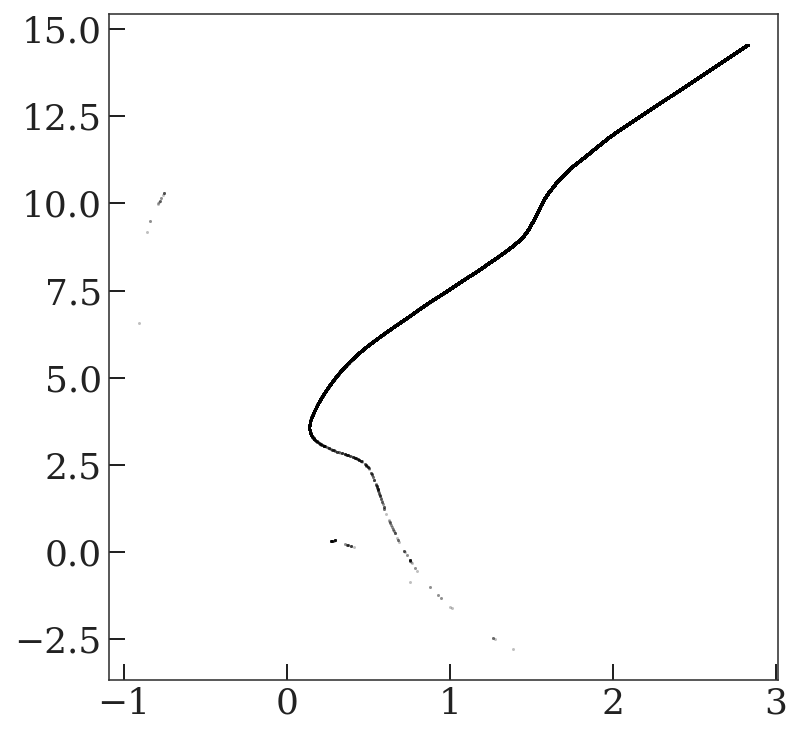

In [ ]:
plt.plot(
    phot["M_g"] - phot["M_i"], phot["M_r"], marker="o", ls="none", ms=1.5, alpha=0.25
)


In [ ]:
stream_galcen = coord.Galactocentric(end_stream.data)
stream_gal = stream_galcen.transform_to(coord.Galactic())

perturb_end_galcen = coord.Galactocentric(w_impact_end[-1].data)
perturb_end_gal = perturb_end_galcen.transform_to(coord.Galactic())

stream_frame = coord.SkyOffsetFrame(origin=perturb_end_gal)

stream_sfr = stream_gal.transform_to(stream_frame)


In [ ]:
for k in eep2mag_interps.keys():
    phot[k] = phot[f"M_{k}"] + stream_gal.distance.distmod.value


(30.0, 12.0)

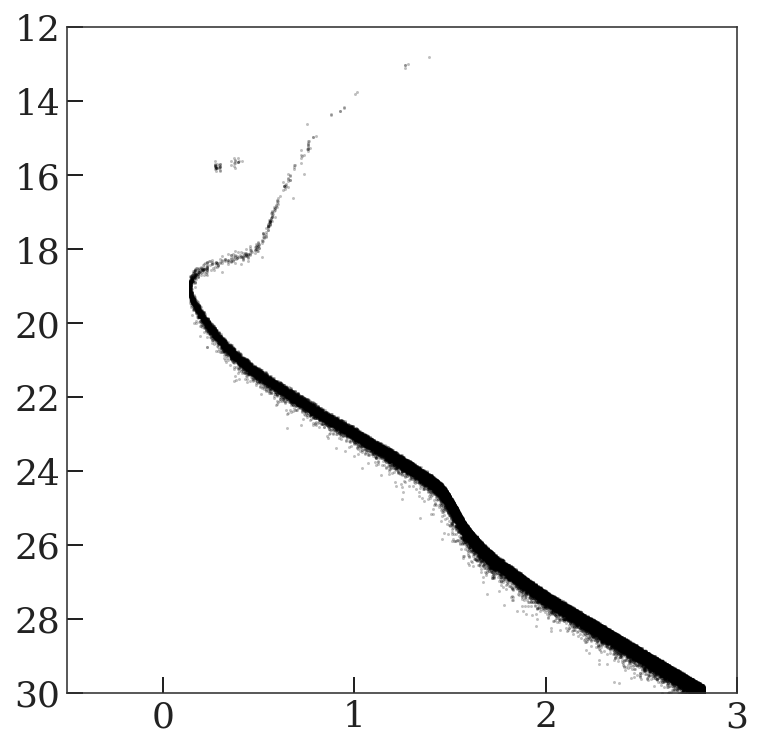

In [ ]:
plt.plot(phot["g"] - phot["i"], phot["r"], marker="o", ls="none", ms=1.5, alpha=0.25)
plt.xlim(-0.5, 3)
plt.ylim(30, 12)


(-5.0, 5.0)

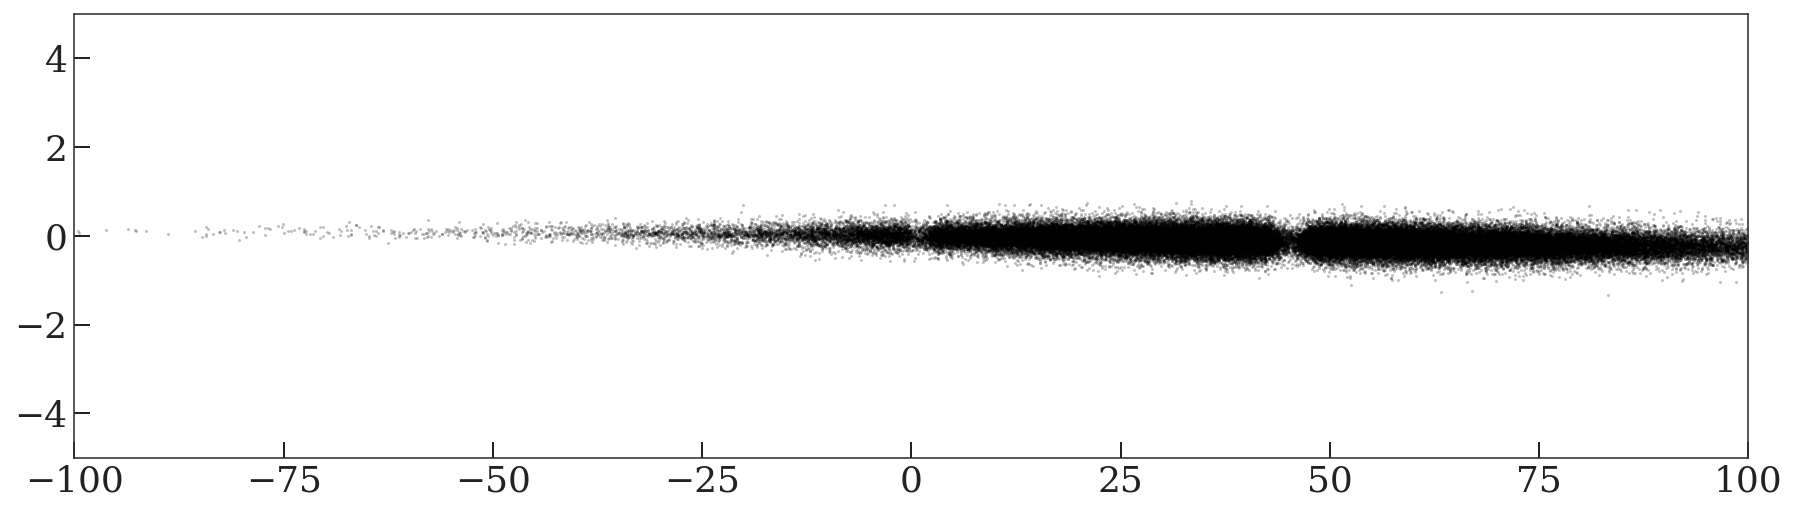

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(
    # stream_gal.l.wrap_at(180*u.deg).degree,
    # stream_gal.b.degree,
    stream_sfr.lon.wrap_at(180 * u.deg).degree,
    stream_sfr.lat.degree,
    marker="o",
    ls="none",
    ms=1.5,
    alpha=0.25,
)
plt.xlim(-100, 100)
plt.ylim(-5, 5)


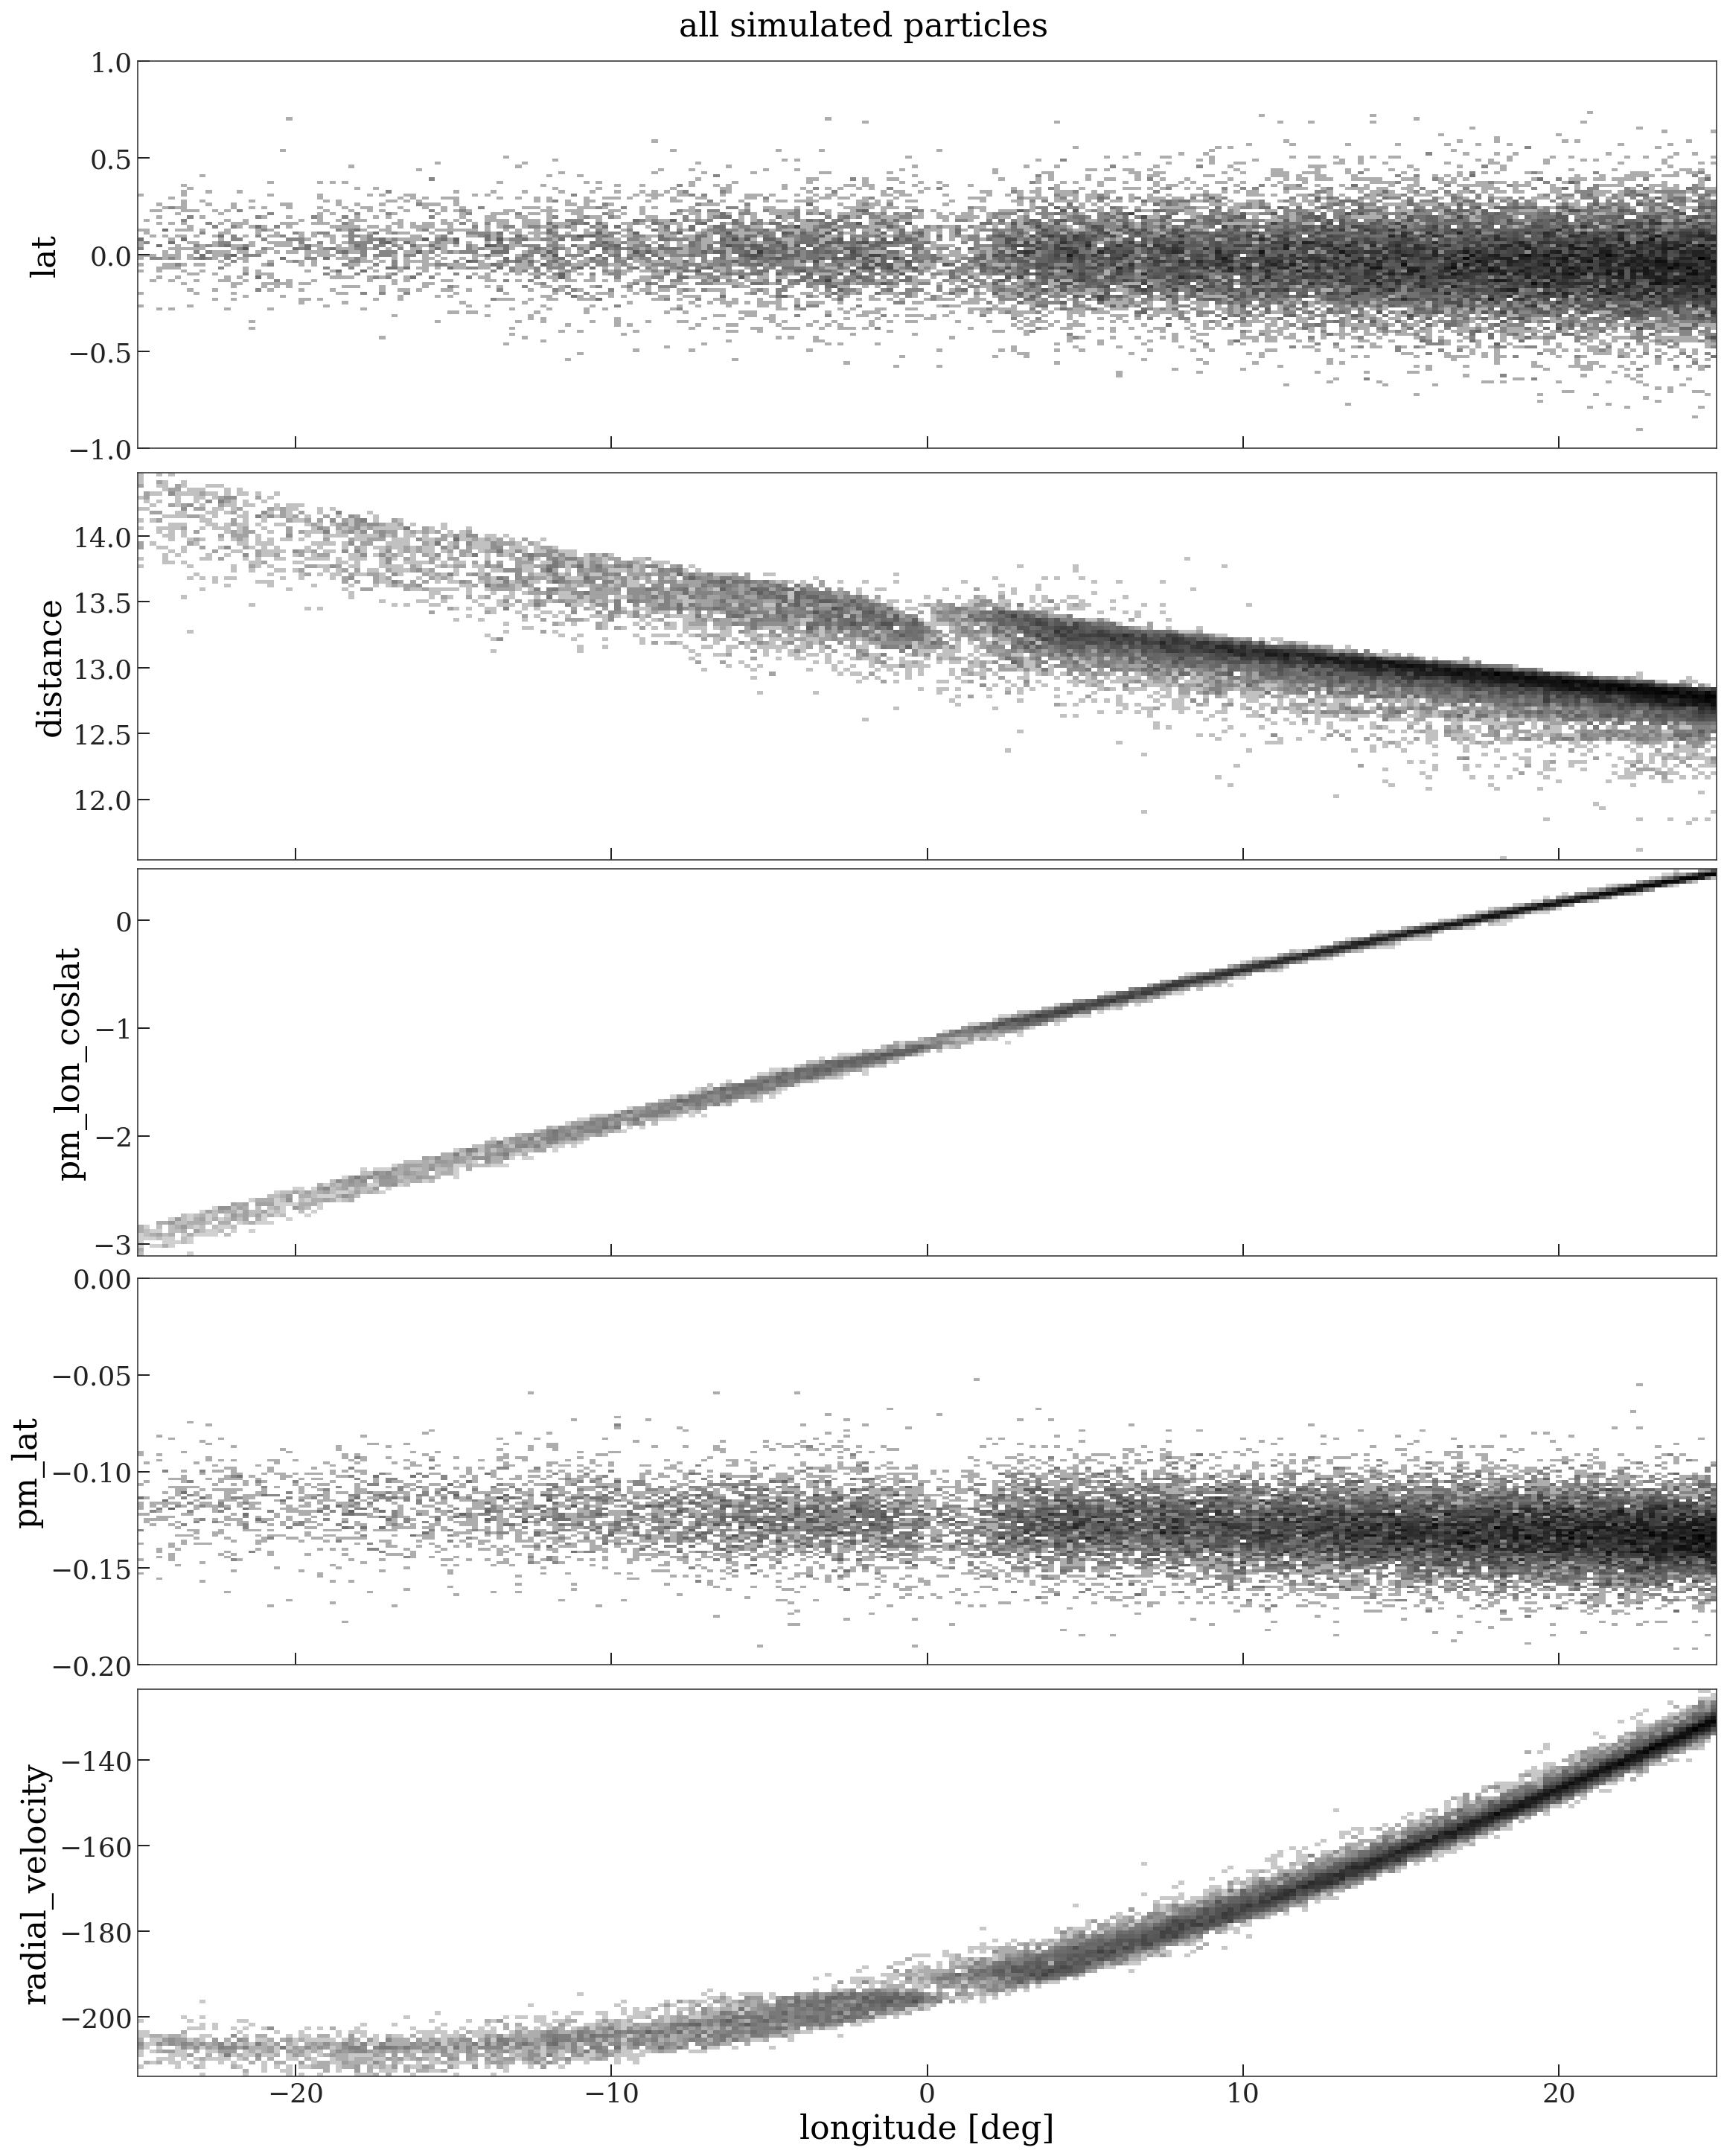

In [ ]:
xlim = (-25, 25)
lon = stream_sfr.lon.wrap_at(180 * u.deg).degree
_mask = (lon > xlim[0]) & (lon < xlim[1])

# ---

fig, axes = plt.subplots(5, 1, figsize=(16, 20), sharex=True, constrained_layout=True)

ax = axes[0]

comps = ["lat", "distance", "pm_lon_coslat", "pm_lat", "radial_velocity"]
lims = [(-1, 1), None, None, (-0.2, 0), None]
for ax, comp, lim in zip(axes, comps, lims):
    ax.hist2d(
        lon[_mask],
        getattr(stream_sfr, comp).value[_mask],
        bins=(np.linspace(*xlim, 256), 101),
        norm=mpl.colors.LogNorm(vmin=0.1),
        cmap="Greys",
    )
    if lim is not None:
        ax.set_ylim(lim)

    ax.set_ylabel(comp)

axes[-1].set(xlim=xlim, xlabel="longitude [deg]")

fig.suptitle("all simulated particles", fontsize=22)


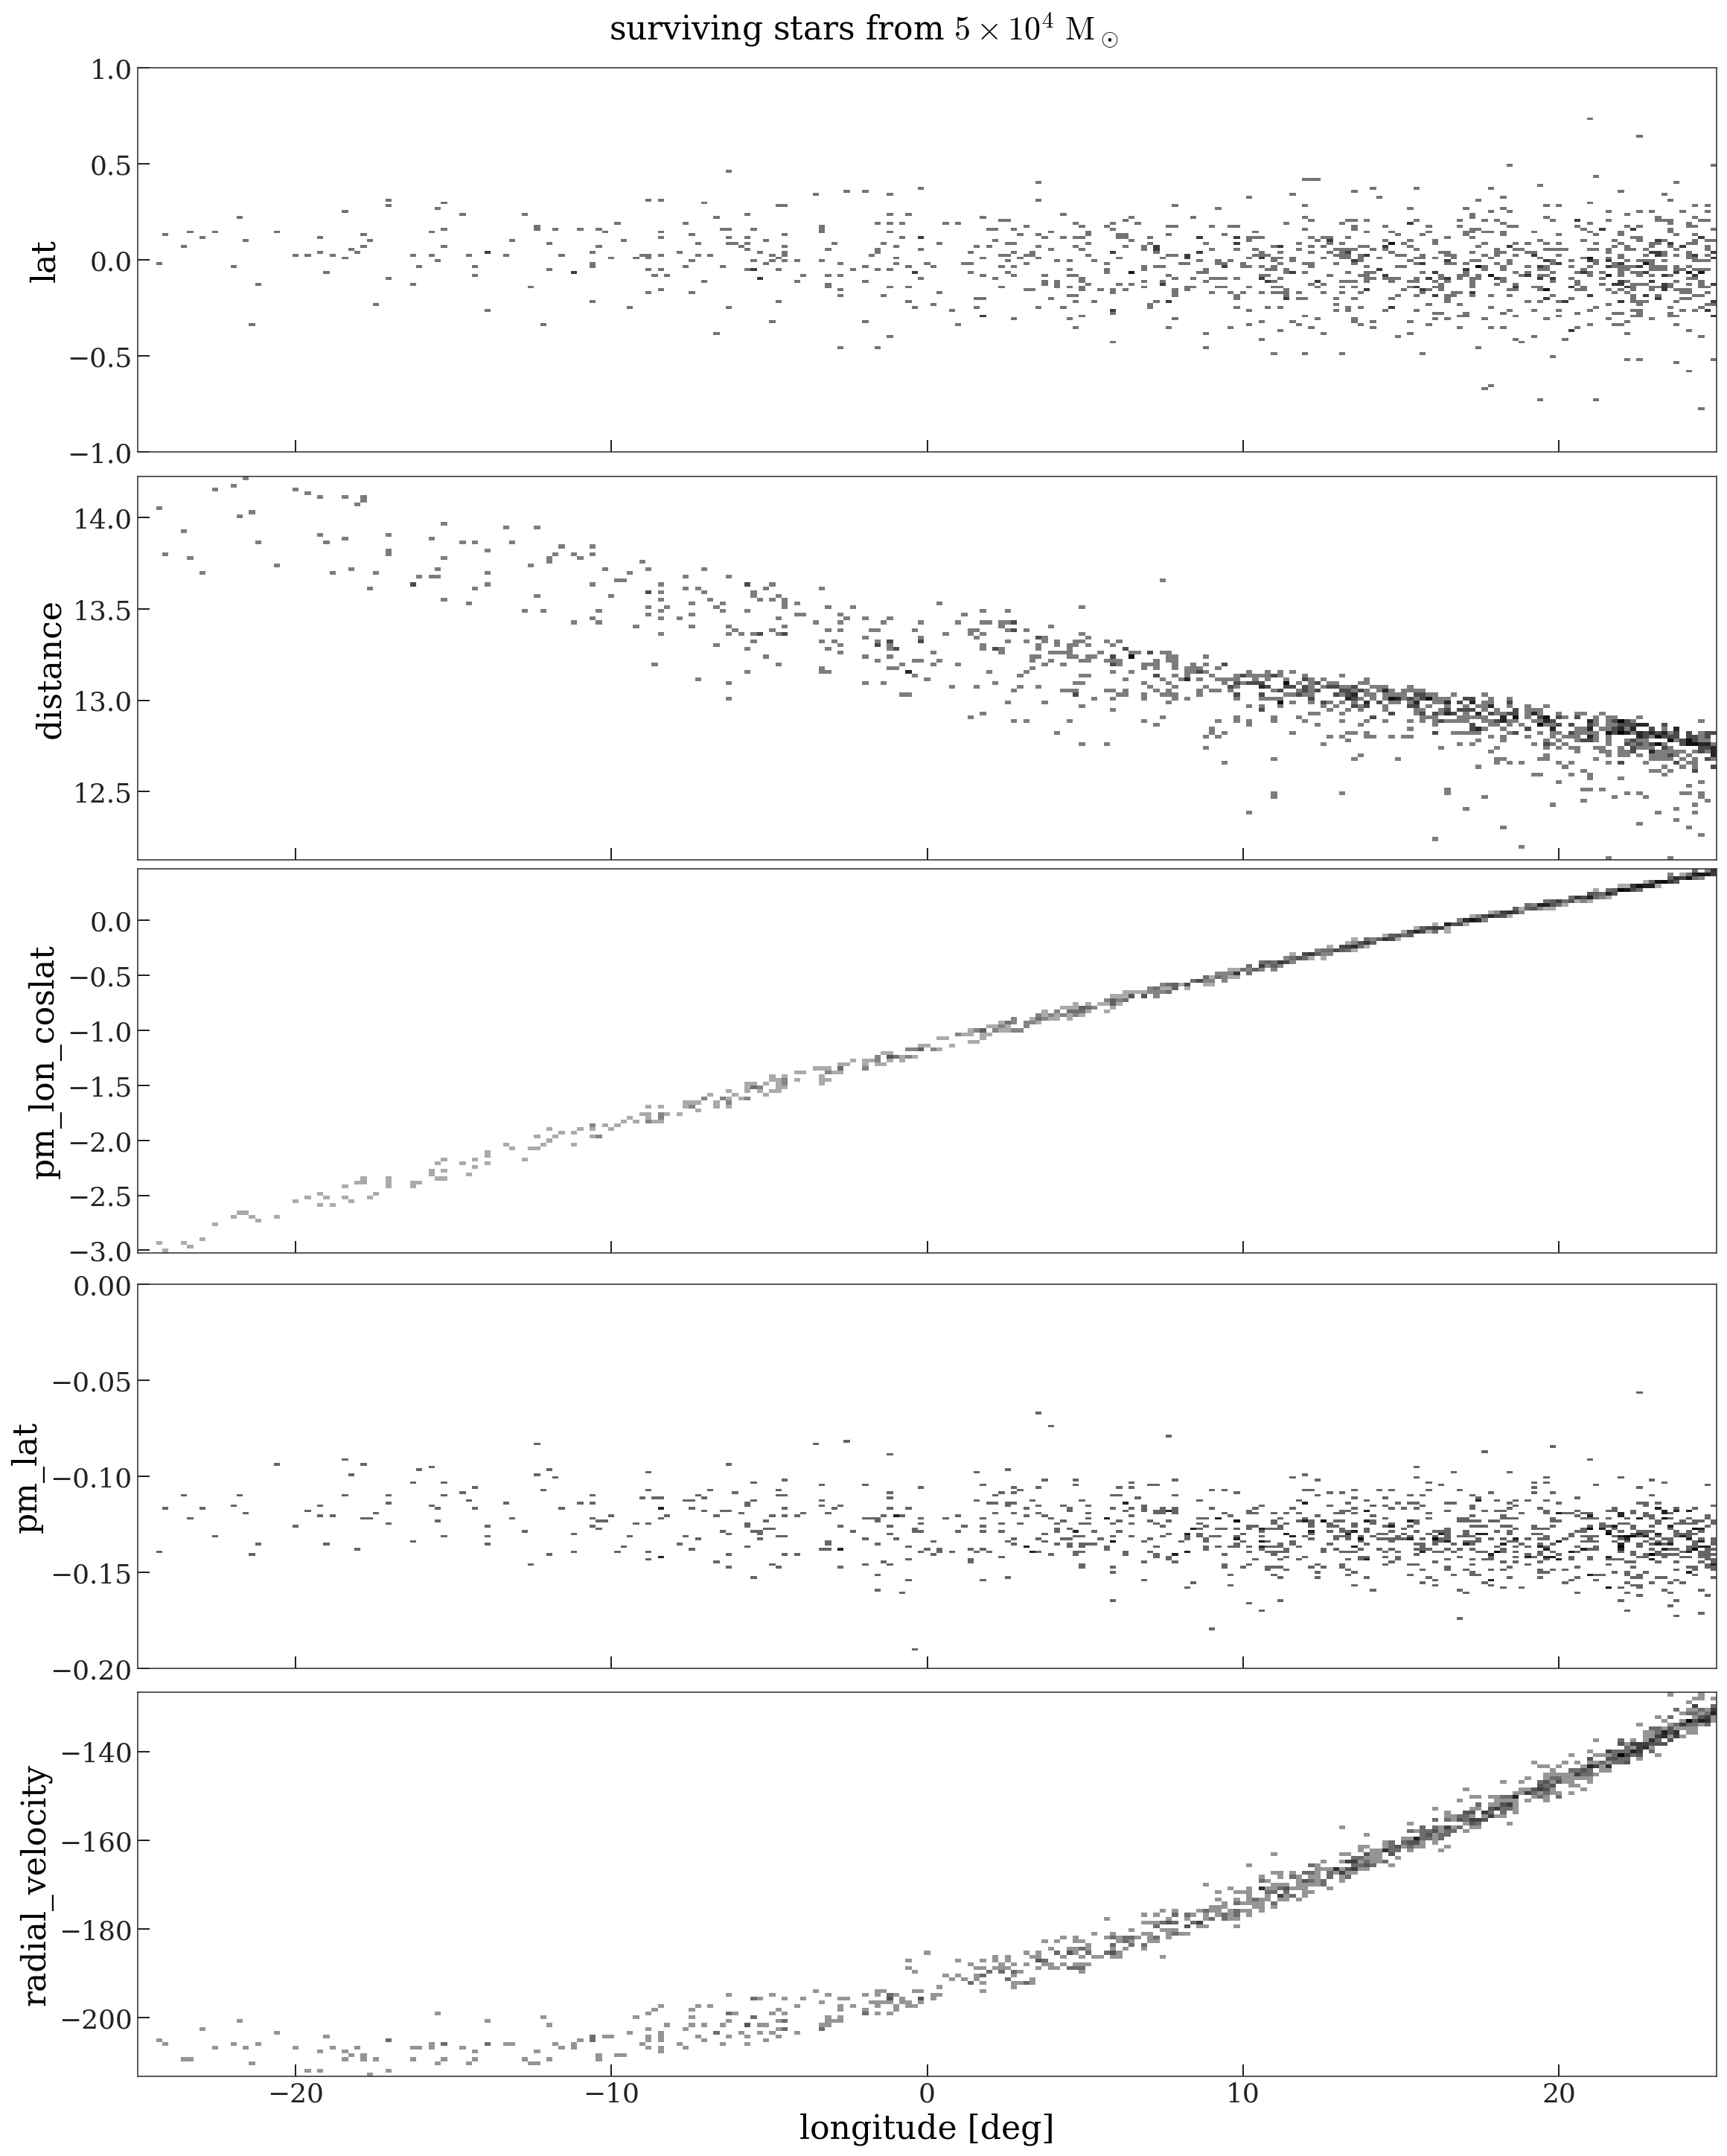

In [ ]:
_mask = (lon > xlim[0]) & (lon < xlim[1]) & (phot["g"] < 22)

# ---

fig, axes = plt.subplots(5, 1, figsize=(16, 20), sharex=True, constrained_layout=True)

ax = axes[0]

comps = ["lat", "distance", "pm_lon_coslat", "pm_lat", "radial_velocity"]
lims = [(-1, 1), None, None, (-0.2, 0), None]
for ax, comp, lim in zip(axes, comps, lims):
    ax.hist2d(
        lon[_mask],
        getattr(stream_sfr, comp).value[_mask],
        bins=(np.linspace(*xlim, 256), 101),
        norm=mpl.colors.LogNorm(vmin=0.1),
        cmap="Greys",
    )
    if lim is not None:
        ax.set_ylim(lim)

    ax.set_ylabel(comp)

axes[-1].set(xlim=xlim, xlabel="longitude [deg]")

fig.suptitle(r"surviving stars from $5\times 10^4~{\rm M}_\odot$", fontsize=22)
